import sys
!{sys.executable} -m pip install pydot

In [1]:
import pandas as pd
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
from matplotlib.ticker import ScalarFormatter

# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

In [2]:
year = "2020"

In [3]:
BuLi = pd.read_csv(r"DataFootball/"+year+"_german_bundesliga_1.csv")
PL = pd.read_csv(r"DataFootball/"+year+"_english_premier_league.csv")
SA = pd.read_csv(r"DataFootball/"+year+"_italian_serie_a.csv")
PD = pd.read_csv(r"DataFootball/"+year+"_spanish_primera_division.csv")
L1 = pd.read_csv(r"DataFootball/"+year+"_french_ligue_1.csv")
NOS = pd.read_csv(r"DataFootball/"+year+"_portugese_liga_nos.csv")
Ere = pd.read_csv(r"DataFootball/"+year+"_dutch_eredivisie.csv")
EC = pd.read_csv(r"DataFootball/"+year+"_english_championship.csv")
Rus = pd.read_csv(r"DataFootball/"+year+"_russian_premier_liga.csv")

In [4]:
DF = pd.concat([BuLi, PL, SA,
                  PD, L1, NOS, 
                  Ere, EC, Rus],ignore_index=True)

In [5]:
DF.shape

(6484, 12)

In [6]:
def DelCol(DF):
    
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    #del DF["player_name"]
    #del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)
DF = DelCol(DF)
DF.head()
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]
DF.head()

,club_name,player_name,club_involved_name,transfer_movement,fee_cleaned
0,1. FC Köln,Emmanuel Dennis,Club Brugge,in,1.08
1,1. FC Köln,Ondrej Duda,Hertha BSC,in,6.30
2,1. FC Köln,Sebastian Andersson,Union Berlin,in,5.85
3,1. FC Köln,Dimitrios Limnios,PAOK Salonika,in,2.97
4,1. FC Köln,Tolu Arokodare,Valmiera,in,0.45


In [7]:
## There is a problem with "double names", e.g. Leicester and Leicester City
def Change(DF,old,new):
    DF.loc[DF["club_name"].isin([old]), ["club_name"]] = new
    DF.loc[DF["club_involved_name"].isin([old]), ["club_involved_name"]] = new
    return DF

In [8]:
old = ["Leicester", "SC Paderborn", "Real Betis", "Sassuolo", "Liverpool", "Watford", "Queens Park Rangers",
       "Brighton & Hove Albion", "Manchester United", "Inter", "UC Sampdoria", "Genoa", "Juventus FC", "Braga",
      "Zenit S-Pb", "Valencia CF", "Marseille", "Espanyol", "Villarreal", "Getafe", "Toulouse", "Cardiff",
      "Paris Saint-Germain", "SL Benfica", "R. Strasbourg", "Racing Club", "Spartak Moscow", "Ajax Amsterdam",
      "Feyenoord Rotterdam", "Dijon FCO", "F. Düsseldorf", "Man City", "E. Frankfurt", "West Ham United",
      "Huddersfield Town", "Charlton", "Nottm Forest", "Swansea", "SS Lazio", "Arsenal FC", "Newcastle",
      "Chelsea FC", "Vitesse Arnheim", "Heerenveen", "Levante", "Brentford", "Bologna", "SV Werder Bremen",
      "Ipswich", "Montpellier", "Bolton", "Marítimo", "Millwall","FC Sochaux-Montbéliard", "Blackpool FC",
       "ES Troyes AC", "Middlesbrough FC", "Vit. Guimarães", "Doncaster", "Norwich City", "Coventry City",
       "Roda JC", "Rostov", "Heerenveen", "Bilbao Athletic", "Leeds United", "Derby", 
       "Dep. La Coruña", "G. Bordeaux", "Naval", "CF Estrela", "Twente FC", "Willem II", 
      "Stade Rennais FC", "Athletic", "1.FC K'lautern", "Preston"]

In [9]:
new = ["Leicester City", "SC Paderborn 07", "Real Betis Balompié", "US Sassuolo", "Liverpool FC", "Watford FC",
      "QPR", "Brighton", "Man Utd", "Inter Milan", "Sampdoria", "Genoa CFC", "Juventus", "SC Braga", 
       "Zenit St. Petersburg", "Valencia", "Olympique Marseille", "RCD Espanyol Barcelona", "Villarreal CF", 
       "Getafe CF", "FC Toulouse", "Cardiff City", "Paris SG", "Benfica", "RC Strasbourg Alsace", "RC Strasbourg Alsace",
      "Spartak", "Ajax", "Feyenoord", "Dijon", "Fortuna Düsseldorf", "Manchester City","Eintracht Frankfurt", "West Ham",
       "Huddersfield","Charlton Athletic", "Nottingham Forest", "Swansea City", "Lazio", "Arsenal", "Newcastle United",
       "Chelsea","Vitesse", "SC Heerenveen", "Levante UD", "Brentford FC", "Bologna FC 1909", "Werder Bremen",
      "Ipswich Town", "Montpellier HSC", "Bolton Wanderers", "CS Marítimo", "Millwall FC","FC Sochaux", "Blackpool",
      "Troyes", "Middlesbrough", "Vitória Guimarães SC", "Doncaster Rovers", "Norwich", "Coventry", 
       "Roda JC Kerkrade", "FK Rostov", "SC Heerenveen", "Athletic Bilbao", "Leeds", "Derby County",
      "Deportivo de La Coruña", "FC Girondins Bordeaux", "Naval 1º de Maio", "CF Estrela Amadora SAD", "Twente Enschede FC",
      "Willem II Tilburg", "Stade Rennais", "Athletic Bilbao", "1. FC Kaiserslautern", "Preston North End"]

In [10]:
for i in range(len(new)):
    DF = Change(DF, old[i], new[i])


In [11]:
# Now that all club names are brought "in line", save the names of the clubse whose full leagues are in the data 
# that means the clubs currently in "club_name" column

Names = set(DF["club_name"])
Names = list(Names)

# If any of these clubs appears on the club_involved_name-column, then the transfer is included twice in our data
# so we delete all "out"-directions of the double transfers

In [12]:
len(Names)

165

In [13]:
DF_clean = pd.DataFrame(columns = DF.columns)

for i in range(DF.shape[0]):
    if not(DF["club_involved_name"].iloc[i] in Names and DF["transfer_movement"].iloc[i]=="out"):
        DF_clean= DF_clean.append(DF.iloc[i])
        
DF = DF_clean
DF = DF.reset_index()
del DF["index"]
del DF["player_name"]

In [14]:
print(DF_clean.loc[DF_clean["player_name"]== "Javi Martínez"]) # Not counted twice!!

Empty DataFrame
Columns: [club_name, player_name, club_involved_name, transfer_movement, fee_cleaned]
Index: []


## Clean the Data

In [15]:
# encode "direction" of transfers: "club_name" is the buyer, "club_involved_name" the seller
for i in range(DF.shape[0]):
    if DF["transfer_movement"].iloc[i] == "out": # switch positions
        source = DF["club_name"].iloc[i]
        DF["club_name"].iloc[i] = DF["club_involved_name"].iloc[i]
        DF["club_involved_name"].iloc[i] = source

del DF["transfer_movement"]

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
DF.head()

,club_name,club_involved_name,fee_cleaned
0,1. FC Köln,Club Brugge,1.08
1,1. FC Köln,Hertha BSC,6.30
2,1. FC Köln,Union Berlin,5.85
3,1. FC Köln,PAOK Salonika,2.97
4,1. FC Köln,Valmiera,0.45


In [17]:
# sort alphabetically
DF  = DF.sort_values(by=['club_name'], ascending = True)
DF = DF.reset_index()
del DF["index"]

DF.head()

,club_name,club_involved_name,fee_cleaned
0,1. FC Kaiserslautern,FC Augsburg,0.045
1,1. FC Köln,Club Brugge,1.080
2,1. FC Köln,Hertha BSC,6.300
3,1. FC Köln,Union Berlin,5.850
4,1. FC Köln,PAOK Salonika,2.970


In [18]:
DF_clean.shape

(826, 5)

### Combine multiple transfers between clubs a and b

In [19]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [20]:
DF = AddFees(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
DF = DF.reset_index()
del DF["index"]
DF

,club_name,club_involved_name,fee_cleaned
0,1. FC Kaiserslautern,FC Augsburg,0.045
1,1. FC Köln,Club Brugge,1.080
2,1. FC Köln,Hertha BSC,6.300
3,1. FC Köln,Union Berlin,5.850
4,1. FC Köln,PAOK Salonika,2.970
...,...,...,...
787,Würzb. Kickers,1.FC Union Berlin,0.063
788,Zaglebie Lubin,Sampdoria,0.225
789,Zenit St. Petersburg,FK Rostov,0.360
790,Zenit St. Petersburg,Sporting CP,18.270


## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [22]:
DFun =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [23]:
DFun["club1"] = np.minimum(DF['club_name'], DF['club_involved_name']) 
DFun["club2"] = np.maximum(DF['club_name'], DF['club_involved_name']) 

In [24]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [25]:
DFun = AddFeesUndirected(DF)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [26]:
G = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [27]:
# Teams of individual leagues 19/20
BL_teams = list(set(BuLi["club_name"])) # Bundesliga
BLList = pd.Series(BL_teams)

PLList = pd.Series(list(set(PL["club_name"])))
SAList = pd.Series(list(set(SA["club_name"])))
PDList = pd.Series(list(set(PD["club_name"])))
L1List = pd.Series(list(set(L1["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [28]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BLList.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

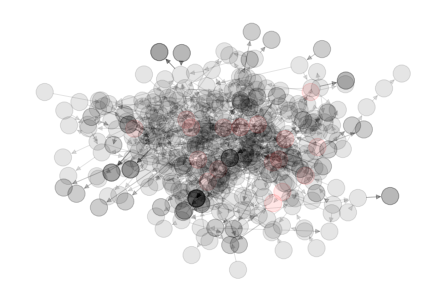

In [29]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [30]:
def Colour1(node):
    if np.sum(BLList.isin([node])):
        out = "red"
    elif np.sum(PLList.isin([node])):
        out = "blue"
    elif np.sum(SAList.isin([node])):
        out = "green" 
    elif np.sum(PDList.isin([node])):
        out = "yellow"
    elif np.sum(L1List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [31]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

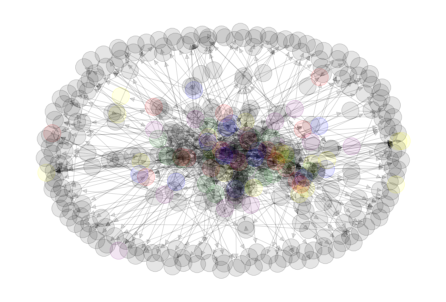

In [32]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)


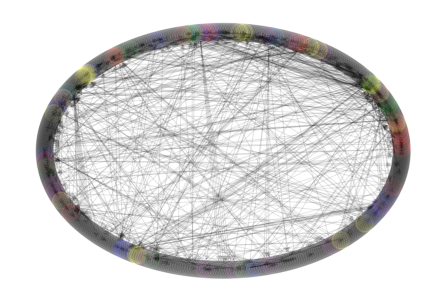

In [33]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks
plt.savefig(year+"_Circular")

In [34]:
# Visual inspection: much less "Small World"-connected than before!

In [35]:
net = Network("800px", "800px",notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")

## Pyvis

In [55]:
g = Network("800px", "800px",notebook=True)
G = nx.from_pandas_edgelist(DFun, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [56]:
def Colour(node):
    # from https://www.hexcolortool.com/#f429ff,0.33
    if np.sum(BLList.isin([node])):
        out = "rgba(244, 15, 11, 0.66)"
    elif np.sum(PLList.isin([node])):
        out = "rgba(41, 155, 255, 0.66)"
    elif np.sum(SAList.isin([node])):
        out = "rgba(41, 255, 77, 0.66)" 
    elif np.sum(PDList.isin([node])):
        out = "rgba(255, 241, 41, 0.66)"
    elif np.sum(L1List.isin([node])):
        out = "rgba(244, 41, 255, 0.66)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [57]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {"physics":False
              })

In [58]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [59]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [60]:
for i in range(DFun.shape[0]):
    g.add_edge(DFun["club_name"].iloc[i], 
              DFun["club_involved_name"].iloc[i],
              value=DFun["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [61]:
g.show("Test.html")

In [ ]:
["CD Nacional", "Al-Batin", "Shimizu S-Pulse", "Portimonense SC", "SV Sandhausen",
"CD Tondela", "Coventry"]

In [43]:
g.save_graph(year+"_allLeagues.html")

In [62]:
DFun.loc[DFun["club_name"]=="Preston North End"]

,club_name,club_involved_name,fee_cleaned
539,Preston North End,Doncaster Rovers,1.50
540,Preston North End,Randers FC,1.35


In [64]:
DFun.loc[DFun["club_involved_name"]=="Sparta"]

,club_name,club_involved_name,fee_cleaned


In [46]:
"Vitória Guimarães SC"

'Vitória Guimarães SC'

In [47]:
PD.loc[PD["club_name"]=="Deportivo de La Coruña"]

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season


In [48]:
DF.loc[DF["club_name"]=="Deportivo de La Coruña"]

,club_name,club_involved_name,fee_cleaned


In [49]:
DF.shape[0]

792

## Analysis

In [50]:
G_undir = nx.from_pandas_edgelist(DFun, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [51]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

#### Small World

In [52]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]
SepList20 = ["CD Nacional", "Al-Batin", "Shimizu S-Pulse", "Portimonense SC", "SV Sandhausen",
            "CD Tondela", "Coventry"]
SepList19 = ["Vitória Setúbal FC","RKC Waalwijk","Covilhã","Luton Town",
         "Portimonense SC","Vitória Guimarães SC","FK Ufa", "VfL Bochum"]
SepList18 = ["CD Nacional", "CD Feirense","FC St. Gallen", "FC Emmen",
           "GD Chaves", "Heracles Almelo","Pau FC", "Leverkusen U19"]
SepList17 = ["CS Marítimo", "Twente Enschede FC", "Ural Yekaterinburg"]
SepList16 = ["Ipswich Town", "Zira FC", "Ross County", "GD Chaves", 
           "FK Orenburg", "SC Heerenveen", "MVV Maastricht",
           "Rotherham United"]
SepList15= ["Ipswich Town", "SV Ried", "NK Olimpija", "Helmond Sport",
         "FC Utrecht","Lienden","Cruzeiro", "Go Ahead Eagles"]
SepList14 = ["Wolverhampton Wanderers","FC Nantes","FK Ufa", "Gaish", "Shinnik",
          "Cracovia", "Athletic Bilbao", "Brisbane Roar"]
SepList13 = ["Leeds United","Vitória Guimarães SC", "Académica Coimbra", "ADO Den Haag",
          "Rio Ave FC","Belenenses SAD", "Tom Tomsk", "Alianza Lima", "Tigre", 
           "Beira-Mar", "Waterford FC"]
SepList12 = ["Mordovia Saransk","Telstar", "CS Marítimo"]
SepList11 = ["Vitesse", "CD Nacional", "SC Olhanense", "SM Caen", "Indjija",
           "FK Krasnodar","Vitória Guimarães SC"]
SepList10 = ["SM Caen","Watford FC", "Sligo Rovers", "Apol. Limassol", "Krylya Sovetov Samara",
          "Roda JC Kerkrade", "FK Rostov", "Athletic Bilbao", "Heracles Almelo"]
SepList09 = ["AS Trencin", "Santo André", "Amkar Perm"]
SepList08 = ["SV Ried"]
SepList07 = ["CF Estrela Amadora SAD"]


#SepList = SepList07

DFcon= DFun.drop(DFun[ DFun['club_involved_name'].isin( SepList)].index)

DFcon = DFcon.drop(DFcon[ DFcon['club_name'].isin(SepList)].index)

#networkx.algorithms.smallworld.sigma(G_undir,niter=10, seed=10)

NameError: name 'SepList' is not defined

In [ ]:
G_undirconnected = nx.from_pandas_edgelist(DFcon, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )




In [ ]:
# Quick check: plot
nt = Network('800px', '800px',notebook=True)
#nt.from_nx(G_undirconnected)


for node in G_undirconnected.nodes:
    nt.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })
    
for i in range(DFcon.shape[0]):
    nt.add_edge(DFcon["club_name"].iloc[i], 
              DFcon["club_involved_name"].iloc[i],
              value=DFcon["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })

nt.show('nx.html')
# Is connected!!

In [ ]:
nt.save_graph(year+"_connection.html")

In [ ]:

start = time.time()

SW = networkx.algorithms.smallworld.sigma(G_undirconnected,niter=20, seed=42)
print(SW)

end = time.time()
print(end - start)

#### Degree Distribution

In [ ]:
networkx.classes.function.degree_histogram(G_undir)

In [ ]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

In [ ]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(np.log(degrees), bins = int(len(G.nodes())/20), log = True)
    plt.show()

plot_degree_dist(G_undir)

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
log_degrees = np.log(degrees)
print(np.mean(log_degrees), np.std(log_degrees), skew(log_degrees))


In [ ]:
plt.hist(degrees, bins = np.arange(-0.5,max(degrees)+0.5,1))
plt.show()

In [ ]:
degree_dist = np.zeros(max(degrees)+1)

In [ ]:
for i in range(max(degrees)):
    degree_dist[i] = np.sum(np.array(degrees) == i)

In [ ]:
degree_dist

In [ ]:
plt.scatter(np.arange(max(degrees)+1), degree_dist)
plt.show()

#### in-degree

In [ ]:
indegrees = [G_dir.in_degree(n) for n in G_dir.nodes()]
indegree_dist = np.zeros(max(indegrees)+1)
for i in range(max(indegrees)+1):
    indegree_dist[i] = np.sum(np.array(indegrees) == i)
    print(i,indegree_dist[i])
plt.scatter(np.arange(max(indegrees)+1), indegree_dist)
plt.show()

In [ ]:
# calculate for everything without 0 (artifact because of limited data)

In [ ]:
indegree_dist

In [ ]:
x = np.arange(1,max(indegrees)+1)
y = indegree_dist[1:]


plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes")
plt.ylabel("Number of Nodes")
plt.savefig(year+"_InNodeDistrPlot")

plt.show()

In [ ]:
# Probably not an argument against Power-Law, but also probably not enough data with really many connections

In [ ]:
#### Out-Degree

In [ ]:
outdegrees = [G_dir.out_degree(n) for n in G_dir.nodes()]
outdegrees_dist = np.zeros(max(outdegrees)+1)
for i in range(max(outdegrees)+1):
    outdegrees_dist[i] = np.sum(np.array(outdegrees) == i)
    print(i,outdegrees_dist[i])


In [ ]:
x = np.arange(1,max(outdegrees)+1)
y = outdegrees_dist[1:]


plt.xscale('log')
plt.yscale('log')
plt.scatter(x, y)
plt.ylim(0.99, 1.5*max(y))
#plt.plot(np.exp(np.arange(0,3,0.01)), 
 #       np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("k - Out-Degree of Nodes")
plt.ylabel("Number of Nodes")
plt.savefig(year+"_OutNodeDistrPlot")

plt.show()

### Clustering

In [ ]:
G_dir = nx.from_pandas_edgelist(DF, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.DiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [ ]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

In [ ]:
# Regular Clustering

Clust = networkx.algorithms.cluster.clustering(G_dir)
BDN_C = np.mean(list(Clust.values()))
print(BDN_C)

In [ ]:
WeightClust = networkx.algorithms.cluster.clustering(G_dir, weight = "fee_cleaned")

In [ ]:
# Weighted Clustering
# https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107

WDN_C = np.mean(list(WeightClust.values()))  ## ?
print(WDN_C)

In [ ]:
NumberNodes = len(list(G_dir.nodes))
NumberEdges = len(list(G_dir.edges))

p = 2*NumberEdges / (NumberNodes*(NumberNodes-1)) # p. 19 in Large Scale Structures....
print(p)

Kind of like Eq. (11) in https://journals.aps.org/pre/abstract/10.1103/PhysRevE.76.026107
it holds that Clustering_WDN < Clustering_BDN ~ p_random

### Calculate Node Strength Distribution

In [ ]:
l=0
for n in G.nodes():
    l = l+1
print(l)
print(len(G.nodes()))
print(int(len(G.nodes())/20))

In [ ]:
# Roughly symmetrical around 1.5?
def plot_strength_dist(G):
    strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
    plt.hist(np.log(strengths), bins = int(len(G.nodes())/20), log = True)
    print(min(strengths), max(strengths))
    plt.savefig(year+"_LogStrengthDistrib")
    plt.show()
plot_strength_dist(G_dir)



In [ ]:
strengths = [G.degree(n, weight="fee_cleaned") for n in G.nodes()]
log_strengths = np.log(strengths)
print(np.mean(log_strengths), np.std(log_strengths), skew(log_strengths))

### Disparity for undirected Network

In [ ]:
A = networkx.linalg.graphmatrix.adjacency_matrix(G_undir, weight = "fee_cleaned")

In [ ]:
print(A.shape)

In [ ]:
## Sanity check: should be 0
print(np.sum(A[i,i] for i in range(A.shape[0])))

In [ ]:
print(DF)

In [ ]:
print(A)

In [ ]:
strengths_undir = [G_undir.degree(n, weight="fee_cleaned") for n in G_undir.nodes()]

In [ ]:
strengths_undir

In [ ]:
j = 0
Y = np.zeros(A.shape[0])
for i in G_undir.nodes:
    row = (A[j,:]/np.sum(A[j,:]))
    row = row.toarray()
    Y[j] = np.sum(row**2)
    j = j+1
    
    
print(j)

In [ ]:
degrees_undir = [G_undir.degree(n) for n in G_undir.nodes()]

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.log(degrees_undir).reshape(-1, 1), np.log(Y).reshape(-1, 1))

In [ ]:
print(reg.coef_[0]) # reasonably close to -1?


In [ ]:


x = degrees_undir
y = Y

plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')

plt.plot(np.exp(np.arange(0,3,0.01)), 
        np.exp(reg.predict(np.arange(0,3,0.01).reshape(-1, 1))), color="red")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel("log(k) - Number of Neighbours")
plt.ylabel("log(Y) - Disparity")
plt.savefig(year+"_DisparityPlot")

plt.show()


## Conclusion
Save some important results as an exported txt

In [ ]:
Out = pd.DataFrame(data={"Year":year,
                         "NumberClubs": NumberNodes,
                         "NumberTransfers": DF_clean.shape[0],
                         "SmallWorld": SW,
                        "DisparityExponent": reg.coef_[0],
                         "BDN_RandomClusteringExpercation": p,
                        "BDN_Clustering": BDN_C,
                        "WDN_Clustering":WDN_C,
                        "MeanLogStrength":np.mean(log_strengths), 
                         "StdLogStrength":np.std(log_strengths), 
                         "SkewnessLogStrength":skew(log_strengths)})

In [ ]:
Out.to_csv(year+"_results.csv",index=False)

In [ ]:
Out

In [ ]:
year